# Recommender Systems with Surprise
- **Created by Andrés Segura Tinoco**
- **Created on May 24, 2019**

## Experiment description
- Model built from a Pandas dataframe
- The algorithm used is: Singular Value Decomposition (SVD)
- Model trained using train and test datasets
- The error of the model was estimated using the RMSE metric

In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate

In [3]:
# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading data

In [4]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.data')

In [5]:
# Read current ratings of the users
data = pd.read_csv(file_path, sep = '\t', names = ['user_id','item_id','rating','timestamp'])
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
# Describe dataframe data
data.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


## 2. Split data

In [7]:
# Split data in training and test
train_data, test_data = train_test_split(data, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (80000, 4)
Test size: (20000, 4)


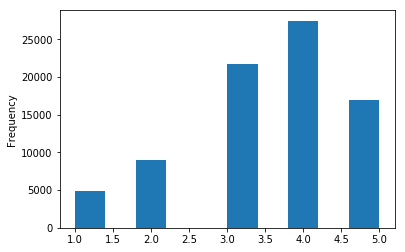

In [8]:
# Plot a ratings histogram of training data 
train_data.rating.plot.hist()

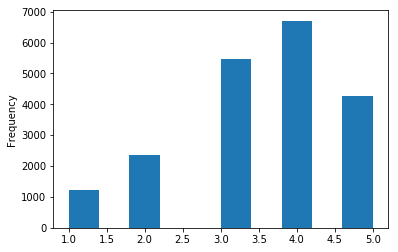

In [9]:
# Plot a ratings histogram of training data
test_data.rating.plot.hist()

**Note:** The two histograms look similar. Both datasets have a similar distribution of the rating variable.

In [10]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [11]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [12]:
mean = data_train.global_mean
print('Train rating', mean)

Train rating 3.5318


In [13]:
mean = data_test.global_mean
print('Test rating', mean)

Test rating 3.5221


In [14]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

## 3. Train the model and measure its error

In [15]:
# Use the famous SVD algorithm.
algo = SVD(n_factors = 5, n_epochs = 200, biased = True, lr_all = 0.005, reg_all = 0, init_mean = 0, init_std_dev = 0.01)

In [16]:
# Train the algorithm on the trainset
algo.fit(data_train)

In [17]:
# Calculate RMSE for training dataset
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.7534


0.753442962702764

In [18]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.9622


0.9621878244247123

## 4. Make predictions

In [19]:
train_data.head(5)

,user_id,item_id,rating,timestamp
85902,917,756,4,882911622
20607,299,185,3,878192039
50338,378,393,3,880057018
83142,269,710,1,891449843
87488,429,737,4,882387505


In [20]:
# Prediction without real rating
p1 = algo.predict(uid = train_data.iloc[0].user_id, iid = train_data.iloc[0].item_id, verbose = True)

user: 917        item: 756        r_ui = None   est = 2.74   {'was_impossible': False}


In [21]:
# Prediction with real rating
p2 = algo.predict(uid = 196, iid = 302, r_ui = 4, verbose = True)

user: 196        item: 302        r_ui = 4.00   est = 4.12   {'was_impossible': False}


## 5. Analyze algorithm matrices

### Users matrix

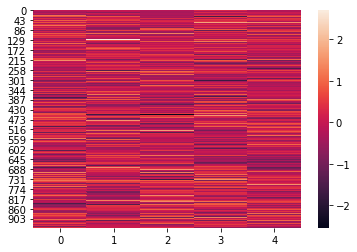

In [22]:
# Plot users matrix
pu = algo.pu
sns.heatmap(pu)

### Items matrix

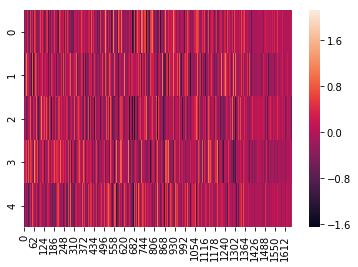

In [23]:
# Plot items matrix
qi = algo.qi
sns.heatmap(qi.T)

You can also view the bias of users $b_u$ and items $b_i$

In [24]:
bu = algo.bu.reshape(algo.bu.shape[0], 1)
bi = algo.bi.reshape(algo.bi.shape[0], 1)

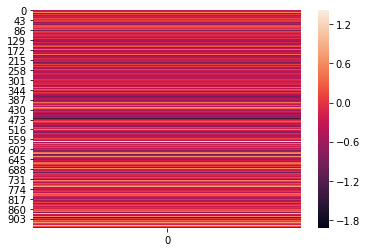

In [25]:
sns.heatmap(bu)

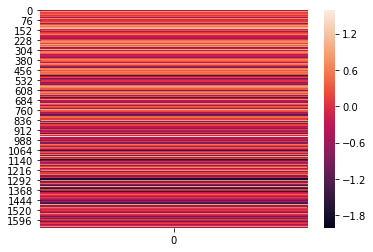

In [26]:
sns.heatmap(bi)

### Reconstruction of original matrix

In [27]:
# Training rating mean
mean = data_train.global_mean

$$ \hat{r}_{ui} = \mu + b_{i} + b_{u} + p_{u} \dot q_{i}^{T} \tag{1} $$

In [28]:
reconstruct = mean + bi.T + bu + (pu).dot((qi).T)

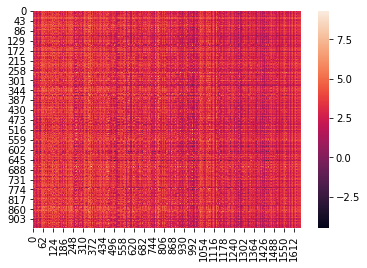

In [29]:
sns.heatmap(reconstruct)

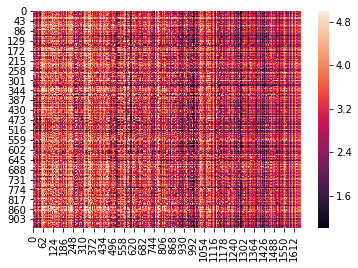

In [30]:
# The prediction is cut since the values are passed 5 and less than 1
reconstruct = np.clip(reconstruct, 1, 5)
sns.heatmap(reconstruct)

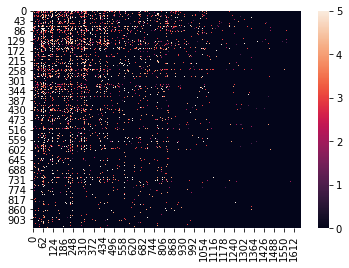

In [31]:
original = np.zeros((data_train.n_users, data_train.n_items))
for (u, i, r) in data_train.all_ratings():
        original[u][i] = r

sns.heatmap(original)

In [32]:
known_entries = (original == 0)
known_entries

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

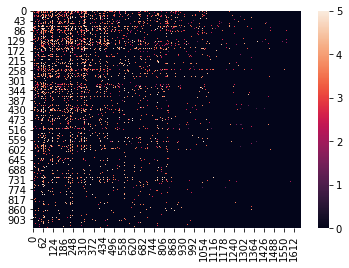

In [33]:
reconstruct[known_entries] = 0
sns.heatmap(reconstruct)

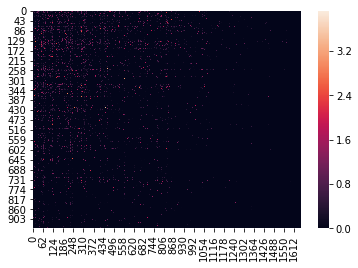

In [34]:
sns.heatmap(np.abs(original - reconstruct))

---
<a href="https://ansegura7.github.io/RS_Surprise/">&laquo; Home</a>